# Proyecto de Segmentación Retail - Clustering

Proyecto Despliegue, en Github y versionado con DVC para realizar un análisis colaborativo por etapas.

--------------------------------------


In [1]:
#librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.stats import entropy

# Configuración general
pd.set_option('display.max_columns', None)

In [18]:
# Carga de datos desde el archivo versionado con DVC
pedidos = pd.read_excel('../data/Data_Set_Global.xlsx', sheet_name='Pedidos')
productos = pd.read_excel('../data/Data_Set_Global.xlsx', sheet_name='Productos')
clientes = pd.read_excel('../data/Data_Set_Global.xlsx', sheet_name='Clientes')

# Mostrar las dimensiones
print(f"Pedidos: {pedidos.shape}")
print(f"Productos: {productos.shape}")
print(f"Clientes: {clientes.shape}")

Pedidos: (5000, 31)
Productos: (268, 6)
Clientes: (2501, 8)


 ------------------------------------------------------------
# 1. Vistazo general y limpieza mínima
 ------------------------------------------------------------

In [19]:
print(pedidos.info())
# Valores faltantes (%)
print((pedidos.isnull().mean()*100).sort_values(ascending=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   order_id                5000 non-null   int64         
 1   product_id              5000 non-null   int64         
 2   quantity                5000 non-null   int64         
 3   unit_price              5000 non-null   float64       
 4   customer_id             5000 non-null   int64         
 5   order_date              5000 non-null   datetime64[ns]
 6   promised_delivery_time  5000 non-null   datetime64[ns]
 7   actual_delivery_time    5000 non-null   datetime64[ns]
 8   delivery_status         5000 non-null   object        
 9   order_total             5000 non-null   float64       
 10  payment_method          5000 non-null   object        
 11  delivery_partner_id     5000 non-null   int64         
 12  store_id                5000 non-null   int64   

In [20]:
display(pedidos.head())

,order_id,product_id,quantity,unit_price,customer_id,order_date,promised_delivery_time,actual_delivery_time,delivery_status,order_total,payment_method,delivery_partner_id,store_id,customer_name,email,phone,address,area,pincode,registration_date,customer_segment,total_orders,avg_order_value,first_name,gender,product_name,mrp,margin_percentage,shelf_life_days,min_stock_level,max_stock_level
0,1001453982,557908,3,942.37,34668988,2023-07-31 04:57:56,2023-07-31 05:13:56,2023-07-31 05:24:56,Slightly Delayed,2774.06,Cash,611,8763,Wishi Varughese,damyanti67@example.net,916060129082,"68/391, Raval\nBelgaum 624810",Nagpur,723012,2023-08-10,Inactive,3,534.37,Wishi,Male,Vitamins,1177.96,20,365,14,53
1,1001900652,217710,2,58.59,30367559,2024-09-08 20:08:07,2024-09-08 20:19:07,2024-09-08 20:32:07,Slightly Delayed,1456.96,Card,85241,2330,Bhavna Guha,isabharwal@example.com,916618110362,"H.No. 38\nPrabhu Nagar, Gorakhpur-773747",Aligarh,885164,2024-09-29,Regular,6,1419.60,Bhavna,Female,Eggs,73.24,20,7,19,53
2,1002438039,709916,3,33.76,85198177,2024-02-17 03:28:02,2024-02-17 03:44:02,2024-02-17 03:43:02,On Time,3775.99,Card,52508,8018,Charita Comar,divyashanker@example.org,917579170820,"60/85, Pant Road\nKollam-512597",Jammu,741033,2023-04-01,Premium,6,1666.01,Charita,Female,Detergent,45.01,25,365,30,88
3,1002526452,444361,2,822.63,97475543,2023-07-31 23:19:05,2023-07-31 23:29:05,2023-07-31 23:33:05,On Time,5001.82,Cash,56579,852,Niharika Nagi,ektataneja@example.org,912987579691,"23, Nayar Path, Bihar Sharif-154625",Udupi,321865,2023-05-13,Premium,13,451.92,Niharika,Female,Pain Reliever,1028.29,20,365,20,71
4,1008158736,721521,1,417.39,62971413,2024-06-10 15:00:16,2024-06-10 15:14:16,2024-06-10 15:23:16,Slightly Delayed,814.33,Card,26508,8514,Baljiwan Agrawal,zayanmenon@example.org,916320225850,145\nRoy Ganj\nMadhyamgram 070455,Amritsar,853732,2023-10-02,Inactive,18,835.09,Baljiwan,Male,Rice,491.05,15,365,20,72


 ------------------------------------------------------------
# 2. Feature engineering útil para el análisis
 ------------------------------------------------------------

In [21]:

pedidos["total_price"]      = pedidos["quantity"] * pedidos["unit_price"]
pedidos["order_date"]       = pd.to_datetime(pedidos["order_date"])
pedidos["promised_delivery_time"] = pd.to_datetime(pedidos["promised_delivery_time"])
pedidos["actual_delivery_time"]   = pd.to_datetime(pedidos["actual_delivery_time"])

pedidos["delivery_delay_min"] = (
    (pedidos["actual_delivery_time"] - pedidos["promised_delivery_time"])
    .dt.total_seconds() / 60
)


 ------------------------------------------------------------
# 3. Estadísticos descriptivos rápidos
 ------------------------------------------------------------

In [22]:
display(pedidos.describe().T)

,count,mean,min,25%,50%,75%,max,std
order_id,5000.0,5029129224.1876,60465.0,2531420519.25,5074377551.0,7488578761.0,9998297778.0,2863532520.894328
product_id,5000.0,509974.9396,4452.0,257719.0,540618.0,747801.0,993331.0,293678.307475
quantity,5000.0,2.0068,1.0,1.0,2.0,3.0,3.0,0.820542
unit_price,5000.0,493.1579,12.32,227.22,448.16,781.08,995.98,298.075647
customer_id,5000.0,50096845.2234,31813.0,24043135.0,49978078.5,76212152.0,99893898.0,29190820.314659
order_date,5000,2024-01-09 00:36:06.259200,2023-03-16 08:10:44,2023-08-17 01:54:09.249999872,2024-01-07 11:35:32,2024-06-03 20:53:15.750000128,2024-11-04 20:29:15,NaN
promised_delivery_time,5000,2024-01-09 00:51:05.743200,2023-03-16 08:27:44,2023-08-17 02:13:24.249999872,2024-01-07 11:47:02,2024-06-03 21:09:30.750000128,2024-11-04 20:43:15,NaN
actual_delivery_time,5000,2024-01-09 00:55:32.323200,2023-03-16 08:24:44,2023-08-17 02:27:24.249999872,2024-01-07 11:51:02,2024-06-03 21:09:30.750000128,2024-11-04 20:47:15,NaN
order_total,5000.0,2201.8617,13.25,1086.215,2100.69,3156.8825,6721.46,1303.02438
delivery_partner_id,5000.0,50050.3182,43.0,24928.5,50262.5,74478.25,99968.0,28802.276922


------------------------------------------------------------
# 4. Correlación de variables numéricas
------------------------------------------------------------

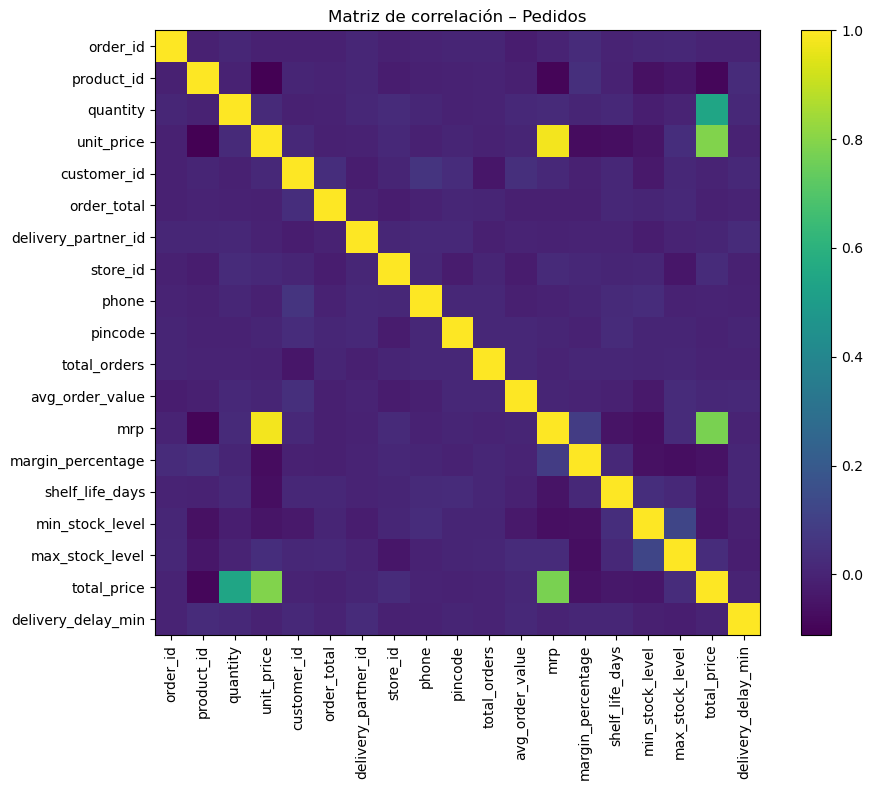

In [23]:
num_cols = pedidos.select_dtypes("number").columns
corr     = pedidos[num_cols].corr()

plt.figure(figsize=(10,8))
plt.imshow(corr, interpolation='none')     # Sin especificar colores
plt.title("Matriz de correlación – Pedidos")
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.tight_layout()
plt.show()